# Predictive Maintenance

The company provides telemetry attributes that are used to helped determine the condition of a device and predict when a maintenance should be performed.  This approach analyzes cost savings over routine versus time-based preventive  maintenance.

## 1. Overview

- From the dataset, we will build a model that will determine whether a device needs maintenance utilizing Machine Learning techinuqes.
- To do this, we will apply sampling methods to an imbalanced dataset and create in-depth data exploratory analysis 
- Our goal is to not only to have optimal metrics, but also to minimize false negatives as much as possible

## 2. Import Libraries and Load Data


### 2.1 Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import warnings
warnings.filterwarnings("ignore")

### 2.2 Data 

In [2]:
df = pd.read_csv('failures.csv')

In [3]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


## 3. Exploratory Data Analysis


### 3.1 Data Analysis

In [4]:
# There are no missing values
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [5]:
# There are a total of 1168 unique devices
len(df['device'].unique())

1168

In [6]:
# 106 total failures 
df['failure'].value_counts()

0    124388
1       106
Name: failure, dtype: int64

There are less than 1% of records that actually fail. This is a representation of imbalanced data. We will group by device to offset this problem.  

### 3.2 Profiling Summary

In [7]:
# df.profile_report(style={'full_width':True})

- The dataset is clean, and there are no missing values. All values are integer type. There is no need to fill in values.
- The dataset is imbalanced, about 0.1% of the classes are failures. We will need to be deal with this problem by either upsampling or downsampling.
- The sparse number of distinctive values in numerous columns most likely represents categorical variables. These attributes are attribute 3, 5, 7, 9, which I will encode for modeling purposes. 
- Attribute 7 and 8 are the same, so we will drop one of the two columns.
- Attribute 2, 3, 4, 5, 7, 9 are highly skewed. We will need to apply transformations. The magnitudes differ by a wide margin. Therefore scaling needs to be done. I used min max scaler to normalize the feature from range 0 to 1 and to keep the outliers.

### 3.3 Device Failure Versus Time

In [8]:
# Converts string into datetime format 
df.date = pd.to_datetime(df.date)

In [9]:
# Returns the month of the date
df['month']=df['date'].dt.month

In [10]:
df.groupby('month').agg({'device':lambda x: x.nunique()})

,device
month,
1,1164
2,726
3,685
4,491
5,424
6,352
7,346
8,334
9,184


The graph below represents the amonut of devices that are checked monthly. From the visualization below, we can see that as each day passes, there are fewer devices that are being checked.

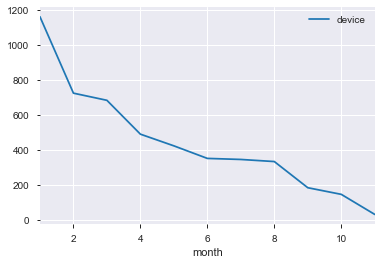

In [11]:
df.groupby('month').agg({'device':lambda x: x.nunique()}).plot()

In [12]:
# Looking at how many devices are checked daily
df['day']=df.date-df.date[0]

The graph below represents the amount of devices that are checked day by day instead of monthly. This also follows the same trend as the daily examination visualization.

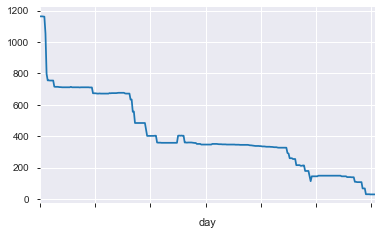

In [13]:
df.groupby('day')['device'].count().plot()

### 3.4 Failed Devices That Are Reused

In [14]:
df_date = df.groupby('device').agg({'date':max})

In [15]:
df_date.head()

,date
device,
S1F01085,2015-01-06
S1F013BB,2015-05-11
S1F0166B,2015-01-06
S1F01E6Y,2015-02-17
S1F01JE0,2015-01-06


In [16]:
df_failure = df.loc[df.failure==1,['device','date']]
df_success = df.loc[df.failure==0,['device','date']]

In [17]:
df_failure

,device,date
4885,S1F0RRB1,2015-01-05
6879,S1F0CTDN,2015-01-07
8823,W1F0PNA5,2015-01-09
11957,W1F13SRV,2015-01-13
12668,W1F1230J,2015-01-14
...,...,...
109927,W1F1CB5E,2015-08-04
114251,Z1F0MRPJ,2015-08-18
122118,S1F0JGJV,2015-10-05
122808,Z1F14BGY,2015-10-09


In [18]:
df_success

,device,date
0,S1F01085,2015-01-01
1,S1F0166B,2015-01-01
2,S1F01E6Y,2015-01-01
3,S1F01JE0,2015-01-01
4,S1F01R2B,2015-01-01
...,...,...
124489,Z1F0MA1S,2015-11-02
124490,Z1F0Q8RT,2015-11-02
124491,Z1F0QK05,2015-11-02
124492,Z1F0QL3N,2015-11-02


In [19]:
df_date.shape,df_failure.shape

((1168, 1), (106, 2))

In [20]:
df['max_date']=df.device.map(df_date.date.to_dict())
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,month,day,max_date
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1,0 days,2015-01-06
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,1,0 days,2015-01-06
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,1,0 days,2015-02-17
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,1,0 days,2015-01-06
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,1,0 days,2015-08-24


In [21]:
dff=df[(df.failure==1)&(df.date!=df.max_date)]
dff

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,month,day,max_date
77958,2015-05-05,S1F136J0,1,131519808,0,0,25,16,343464,8,8,0,5,124 days,2015-05-06
79590,2015-05-09,W1F0KCP2,1,176861128,10392,0,121,6,310699,0,0,0,5,128 days,2015-05-11
79601,2015-05-09,W1F0M35B,1,141805096,0,0,1,7,267203,0,0,0,5,128 days,2015-05-11
101999,2015-07-12,S1F0GPFZ,1,236544080,0,0,0,9,264594,0,0,0,7,192 days,2015-07-24
104223,2015-07-18,W1F11ZG9,1,32671632,368,9,486,3,344433,0,0,1,7,198 days,2015-08-17


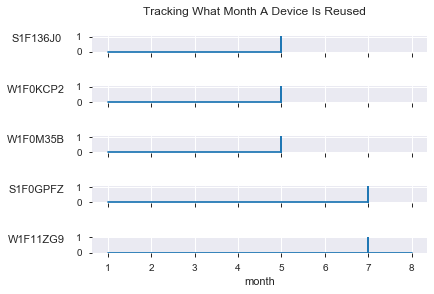

In [22]:
fig, axs = plt.subplots(5, sharex=True, sharey=True, gridspec_kw={'hspace': 2})
fig.suptitle('Tracking What Month A Device Is Reused')
plt.xlabel('month')


axs[0].plot(df.loc[df['device']=='S1F136J0',['failure','month']]['month'],df.loc[df['device']=='S1F136J0',\
         ['failure','month']]['failure'])
axs[1].plot(df.loc[df['device']=='W1F0KCP2',['failure','month']]['month'],df.loc[df['device']=='W1F0KCP2',\
         ['failure','month']]['failure'])
axs[2].plot(df.loc[df['device']=='W1F0M35B',['failure','month']]['month'],df.loc[df['device']=='W1F0M35B',\
         ['failure','month']]['failure'])
axs[3].plot(df.loc[df['device']=='S1F0GPFZ',['failure','month']]['month'],df.loc[df['device']=='S1F0GPFZ',\
         ['failure','month']]['failure'])
axs[4].plot(df.loc[df['device']=='W1F11ZG9',['failure','month']]['month'],df.loc[df['device']=='W1F11ZG9',\
         ['failure','month']]['failure'])

devices = ['S1F136J0','W1F0KCP2','W1F0M35B','S1F0GPFZ','W1F11ZG9']
count = 0

for ax in axs:
    ax.set_ylabel(devices[count], rotation =0, labelpad= 40 )
    count = count + 1


There are a total of 5 devices that were reused

## 4. Feature Engineering

### 4.1 Group By Device

We will start with a dataframe that is grouped by device.

In [23]:
df1 = df.groupby('device').agg({'date':max})

In [24]:
df1=df1.reset_index()
df1.head()

,device,date
0,S1F01085,2015-01-06
1,S1F013BB,2015-05-11
2,S1F0166B,2015-01-06
3,S1F01E6Y,2015-02-17
4,S1F01JE0,2015-01-06


In [25]:
df =df.reset_index(drop =True)
df2 = pd.merge(df1,df,how='left', on = ['device','date'])
df2.shape

(1168, 15)

In [26]:
df2.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,month,day,max_date
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,0,7,1,5 days,2015-01-06
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,0,5,130 days,2015-05-11
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,0,1,5 days,2015-01-06
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,0,2,47 days,2015-02-17
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,0,1,5 days,2015-01-06


### 4.2 Date Feature

In [27]:
df2.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,month,day,max_date
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,0,7,1,5 days,2015-01-06
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,0,5,130 days,2015-05-11
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,0,1,5 days,2015-01-06
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,0,2,47 days,2015-02-17
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,0,1,5 days,2015-01-06


In [28]:
#make classification and continous variables
cat_columns = ['attribute3','attribute5','attribute7','attribute9','day']
df2[cat_columns]= df2[cat_columns].astype(str)

In [29]:
df2['day']= df2['day'].apply( lambda x: int(x.split(' ')[0]))

In [30]:
df2.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,month,day,max_date
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,0,7,1,5,2015-01-06
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,0,5,130,2015-05-11
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,0,1,5,2015-01-06
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,0,2,47,2015-02-17
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,0,1,5,2015-01-06


In [31]:
df2.drop(['date','max_date'],axis=1,inplace=True)

In [32]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1167
Data columns (total 13 columns):
device        1168 non-null object
failure       1168 non-null int64
attribute1    1168 non-null int64
attribute2    1168 non-null int64
attribute3    1168 non-null object
attribute4    1168 non-null int64
attribute5    1168 non-null object
attribute6    1168 non-null int64
attribute7    1168 non-null object
attribute8    1168 non-null int64
attribute9    1168 non-null object
month         1168 non-null int64
day           1168 non-null int64
dtypes: int64(8), object(5)
memory usage: 127.8+ KB


### 4.3 Device Class Feature

In [33]:
# The first four characters of a device represents the brand of device
df2['device_class'] = df2.device.apply(lambda x: x[:4])

In [34]:
dev=pd.crosstab(df2['device_class'],df2['failure'])

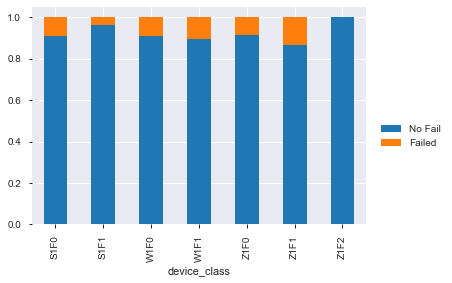

In [35]:
dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True).legend(["No Fail", "Failed"], bbox_to_anchor=(1.25, 0.5))

In [36]:
df.head() 

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,month,day,max_date
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1,0 days,2015-01-06
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,1,0 days,2015-01-06
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,1,0 days,2015-02-17
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,1,0 days,2015-01-06
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,1,0 days,2015-08-24


## 5. Preprocessing Data 

### 5.1 Data Transformation

Text(0.5, 1.0, 'Log-Transformed Distribution')

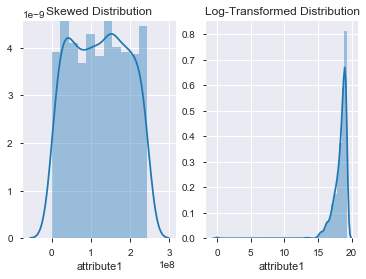

In [37]:
f, axarr = plt.subplots(1,2)
sns.distplot(df2['attribute1'],ax=axarr[0])
axarr[0].set_title('Skewed Distribution')
sns.distplot(np.log(1+df2['attribute1']),ax=axarr[1])
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

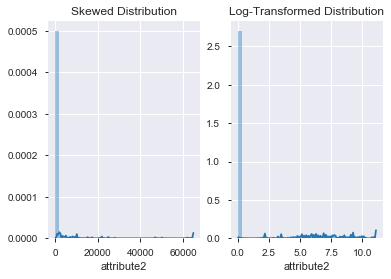

In [38]:
f, axarr = plt.subplots(1,2)
sns.distplot(df2['attribute2'],ax=axarr[0])
axarr[0].set_title('Skewed Distribution')
sns.distplot(np.log(1+df2['attribute2']),ax=axarr[1])
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

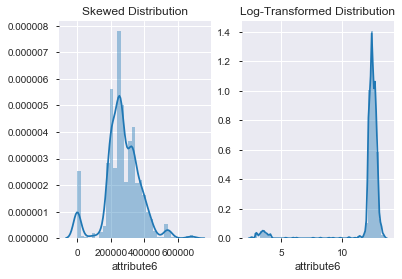

In [39]:
f, axarr = plt.subplots(1,2)
sns.distplot(df2['attribute6'],ax=axarr[0])
axarr[0].set_title('Skewed Distribution')
sns.distplot(np.log(1+df2['attribute6']),ax=axarr[1])
axarr[1].set_title('Log-Transformed Distribution')

In [40]:
from sklearn import preprocessing
#scaling
# Create scaler
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))

# transformation = ['attribute1','attribute2', 'attribute6']

# df2[transformation] = minmax_scale.fit_transformform(df2[transformation])


# Scale feature
df2['attribute1'] = minmax_scale.fit_transform(df2['attribute1'].values.reshape(-1,1))
df2['attribute2'] = minmax_scale.fit_transform(df2['attribute2'].values.reshape(-1,1))
df2['attribute6'] = minmax_scale.fit_transform(df2['attribute6'].values.reshape(-1,1))


In [41]:
df2.head()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,month,day,device_class
0,S1F01085,0,0.529456,0.000864,0,52,6,0.594054,0,0,7,1,5,S1F0
1,S1F013BB,0,0.475391,0.000000,0,0,5,1.000000,0,0,0,5,130,S1F0
2,S1F0166B,0,0.030583,0.000000,3,0,6,0.587353,0,0,0,1,5,S1F0
3,S1F01E6Y,0,0.605558,0.000000,0,0,12,0.376521,0,0,0,2,47,S1F0
4,S1F01JE0,0,0.762033,0.000000,0,0,6,0.598040,0,0,0,1,5,S1F0


### 5.2 Drop Identical Column

In [42]:
# Drop attribute8 column because it is a duplicate of attribute7
df2 =df2.drop(columns = ['attribute8'])

In [43]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1167
Data columns (total 13 columns):
device          1168 non-null object
failure         1168 non-null int64
attribute1      1168 non-null float64
attribute2      1168 non-null float64
attribute3      1168 non-null object
attribute4      1168 non-null int64
attribute5      1168 non-null object
attribute6      1168 non-null float64
attribute7      1168 non-null object
attribute9      1168 non-null object
month           1168 non-null int64
day             1168 non-null int64
device_class    1168 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 127.8+ KB


### 5.3 Converting Categorical Features

We do not have sufficient information to determine if there are ordinal values. Therefore, we will do a basic encoding.

In [44]:
df2 = pd.get_dummies(df2, drop_first = True)

## 6. Model

### 6.1 Defining Train Test

In [45]:
y= df2['failure']
result =df2.drop(columns = ['failure'])

In [46]:
#import models
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(result, y, test_size=0.25, random_state=42)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((876, 1362), (292, 1362), (876,), (292,))

### 6.2 Libraries

In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import learning_curve, GridSearchCV, KFold, StratifiedKFold, StratifiedShuffleSplit
from imblearn.metrics import geometric_mean_score as geo
from imblearn.metrics import make_index_balanced_accuracy as iba
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced

# from imblearn import under_sampling 
# from imblearn import over_sampling
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)




#parameters for tDMassess function
g = GaussianNB()
b = BernoulliNB()
k = KNeighborsClassifier()
log = LogisticRegression()
gbc = GradientBoostingClassifier()
r = RandomForestClassifier()
# r = RandomForestClassifier(n_estimators=5000, random_state=21)
xgb = XGBClassifier(random_state=0)
svc = SVC()
algorithms = [g, b, k, log, gbc, r, xgb, svc]
names = ['GaussianNB', 'BernoulliNB', 'K Nearest', 'Logistic', 'Gradient Boosting', 'Random Forest', 'XG Boost', 'SVC']

### 6.3 Oversample within Cross-Validation

In our dataset, the majority of the results do not fail. As mentioned above, only about 0.1% of the classes are failures. Because we have a scarcity of data, we will choose to oversample on the failure to provide more data for modeling. We have to be careful to split the dataset first and then oversample because we do not want to duplicate observations from the train set into the test set to avoid overfitting or memorization of data points.

In [50]:
def kfoldAssessROS(X_train, y_train, algorithms, names ):
    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()
    Accuracy = []
    Precision= []
    Recall= []
    F1 = []

    #fit the data
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=69,shuffle=True)
        accuracy = []
        precision= []
        recall= []
        f1 = []
        for train_index,test_index in kf.split(X_train,y_train):
#             print('\n{} of kfold {}'.format(j,kf.n_splits))
            xtrain, xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest= y_train[train_index],y_train[test_index]
            xtrain_resample,ytrain_resample=ros.fit_sample(xtrain, ytrain)
            fit= algorithms[i].fit(xtrain_resample,ytrain_resample)
            y_pred_test = fit.predict(xtest)
            
            accuracy.append(accuracy_score(ytest,y_pred_test))
            precision.append(precision_score(ytest,y_pred_test))
            recall.append(recall_score(ytest,y_pred_test))
            f1.append(f1_score(ytest,y_pred_test))
            j+=1
        mean_accuracy = np.mean(accuracy)
        mean_precision = np.mean(precision)
        mean_recall = np.mean(recall)
        mean_f1 = np.mean(f1)
        Accuracy.append(mean_accuracy)
        Precision.append(mean_precision)
        Recall.append(mean_recall)
        F1.append(mean_f1)
        
    metrics = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1'], index = names)
    metrics['Accuracy'] =Accuracy
    metrics['Precision'] = Precision
    metrics['Recall']=Recall
    metrics['F1']=F1
    return metrics.sort_values('F1',ascending = False)

In [51]:
kfoldAssessROS(X_train, y_train, algorithms, names )

,Accuracy,Precision,Recall,F1
XG Boost,0.956662,0.746857,0.781667,0.760353
K Nearest,0.950921,0.714886,0.729167,0.718039
Gradient Boosting,0.945227,0.661520,0.766667,0.709437
SVC,0.889349,0.439443,0.834167,0.574620
BernoulliNB,0.866492,0.370065,0.661667,0.471963
Random Forest,0.918960,0.630159,0.246667,0.339809
Logistic,0.898434,0.407381,0.299167,0.336912
GaussianNB,0.253445,0.089662,0.816667,0.161569


- precision is masurement of relevant results
- recall is a measure of how many truly relevant results are returned
- specificity
- f1 is the harmonic mean of precision and recall

### 6.4 ROC Curve

The Receiver Operating Characteristic Curve compares the true positive rate versus the false positive rate. I have ran several models and plotted their ROC curve to determine which model provides the best combination of TPR and FPR based on the largest area under the curve (AUC). The XGBoost Model with an area of 0.92 provided the best result.

In [52]:
X_test=X_test.as_matrix()
y_test=y_test.as_matrix()

probs1 = xgb.predict_proba(X_test)
probs2 = k.predict_proba(X_test)
probs3 = gbc.predict_proba(X_test)
probs4 = r.predict_proba(X_test)
probs1 = probs1[:,1]
probs2 = probs2[:,1]
probs3 = probs3[:,1]
probs4 = probs4[:,1]

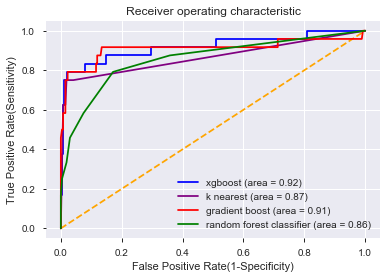

In [53]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probs1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probs2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, probs3)
fpr4, tpr4, thresholds4 = roc_curve(y_test, probs4)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.plot(fpr1, tpr1, color = 'blue', label='xgboost (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color = 'purple', label='k nearest (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color = 'red', label='gradient boost (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color = 'green', label='random forest classifier (area = %0.2f)' % roc_auc4)
plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 6.5 Learning Curve

The learning curve determines whether the models needs more samples to improve its score. The colored range surrounding the lines represents the amount of variance error. 

In [54]:
kfold = StratifiedKFold(n_splits=10)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

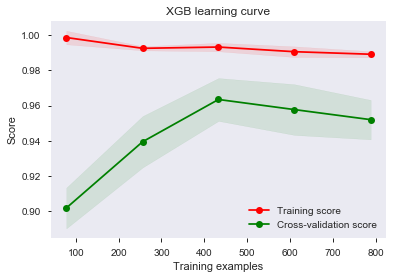

In [55]:
plot_learning_curve(xgb,"XGB learning curve",X_train,y_train,cv=kfold)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

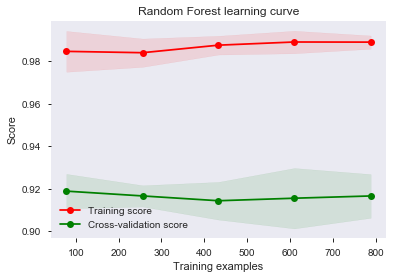

In [56]:
plot_learning_curve(r,"Random Forest learning curve",X_train,y_train,cv=kfold)

Since we are doing a classification analysis, we will ensemble models by voting. 

### 6.6 Grid Search

To improve our model's score, we will perform a grid search to find the best combination of parameters. Cross validation is used to allow more data to be used for model to learn and decide the parameters. 

In [65]:
estimators = [25, 50, 100, 150, 200]
learning_rate = [0.01,0.05,0.1,0.15,0.2, 0.25]

cv = KFold(n_splits= 5 , random_state=0)

## Setting param for param_grid in GridSearchCV. 
param = {'model__estimators': estimators, 'model__learning_rate': learning_rate}

## Creating pipeline
xgbpipe = Pipeline([('resample', ros), ('model', xgb)])

# Perform grid search based on roc_auc scoring
xgbgrid = GridSearchCV(xgbpipe, param_grid=param, cv=cv, scoring='roc_auc')
xgbgrid.fit(X_train.as_matrix(), y_train.as_matrix())

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('resample',
                                        RandomOverSampler(random_state=0,
                                                          ratio=None,
                                                          return_indices=False,
                                                          sampling_strategy='auto')),
                                       ('model',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,...
                                                      objective=

In [67]:
print (xgbgrid.best_score_)
print (xgbgrid.best_params_)
print(xgbgrid.best_estimator_)

0.9690123112156088
{'model__estimators': 25, 'model__learning_rate': 0.25}
Pipeline(memory=None,
         steps=[('resample',
                 RandomOverSampler(random_state=0, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, estimators=25, gamma=0,
                               learning_rate=0.25, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
           

In [68]:
xgb_pred = xgbgrid.predict(X_test)
xgb_proba = xgbgrid.predict_proba(X_test)
xgb_pred = pd.Series(xgb_pred)

In [72]:
def score_result(y, pred):
    print ('Accuracy Score is', accuracy_score(y,pred))
    print ('Precision Score is', precision_score(y, pred))
    print ('Recall Score is', recall_score(y, pred))
    print ('f1_score is ', f1_score(y, pred))

In [73]:
score_result(y_test, xgb_pred)

Accuracy Score is 0.9657534246575342
Precision Score is 0.85
Recall Score is 0.7083333333333334
f1_score is  0.7727272727272727


## 7. Deployment

In [87]:
xgb_proba1 = pd.DataFrame(xgb_proba,columns = ['Prob_0', 'Prob_1'])
xgb_pred1 = pd.DataFrame(xgb_pred,columns = ['predict'])

In [88]:
y1 = pd.DataFrame(y_test)
y1.columns = ['Actual']
final = pd.concat([y1,xgb_pred1], axis =1)
final = pd.concat([final,xgb_proba1], axis =1)

In [89]:
final

,Actual,predict,Prob_0,Prob_1
0,0,0,0.999069,0.000931
1,0,0,0.998158,0.001842
2,0,0,0.998827,0.001173
3,0,0,0.999561,0.000439
4,0,0,0.999370,0.000630
...,...,...,...,...
287,0,0,0.996198,0.003802
288,0,0,0.997527,0.002473
289,0,0,0.988637,0.011363
290,0,0,0.998296,0.001704


In [90]:
final[final['Actual'] ==1]

,Actual,predict,Prob_0,Prob_1
28,1,0,0.878898,0.121102
40,1,1,0.040144,0.959856
50,1,1,0.027926,0.972074
73,1,1,0.000439,0.999561
75,1,1,0.093402,0.906598
102,1,0,0.748427,0.251573
106,1,1,0.039008,0.960992
108,1,1,0.138339,0.861661
157,1,1,0.000839,0.999161
167,1,0,0.974244,0.025756


## 8. Conclusion

We were able to create a model that solves our overfitting problem. While we were able to predict very highly in accuracy and precision, the recall score and f1 score is slightly lower. These scores may be improved if we have more information about the attributes. Time series analysis may be applied as well to analyze what caused the dip in checking devices in the first few days. 